# Data pre-processing

In [ ]:
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Load the data from the uploaded CSV file
file_path = "/content/combined_mutation_CNV.csv"
data = pd.read_csv(file_path)

# Separate the features and labels
labels = data["Subtype"].values
features = data.drop(columns=["Subtype", "Sample"]).values

# Convert to numpy arrays
labels = np.array(labels)
labels[labels=='PDM'] = 0
labels[labels=='SCM'] = 1

# Encode the target variable if necessary
if labels.dtype == 'object' or labels.dtype.name == 'category':
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)

features = np.array(features)

# Output the results
print("Labels:", labels.shape)
print("Features:", features.shape)


Labels: (43,)
Features: (43, 656)


In [ ]:
# Create a MinMaxScaler object with a feature range of -1 to 1
min_max_Scalar = preprocessing.MinMaxScaler(feature_range=(-1, 1))

# Fit the MinMaxScaler to the data (excluding the last column) and transform the data
# This scales the features to the specified range (-1 to 1)
features = min_max_Scalar.fit_transform(features)

# Convert the transformed data to a NumPy array
features = np.asarray(features)

# Helper Functions


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

In [ ]:
# Define custom Dataset
class FewShotDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define the Prototypical Network
class ProtoNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ProtoNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

def compute_prototypes(embeddings, labels):
    prototypes = []
    for label in torch.unique(labels):
        prototypes.append(embeddings[labels == label].mean(0))
    return torch.stack(prototypes)

def euclidean_distance(a, b):
    return ((a - b) ** 2).sum(dim=1)

def train_and_evaluate(few_shot_size=10, epochs=20, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    fold_accuracies = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Select few-shot samples
        train_indices = np.random.choice(len(X_train), few_shot_size, replace=False)
        X_few_shot = X_train[train_indices]
        y_few_shot = y_train[train_indices]

        few_shot_dataset = FewShotDataset(X_few_shot, y_few_shot)
        few_shot_loader = DataLoader(few_shot_dataset, batch_size=2, shuffle=True)

        val_dataset = FewShotDataset(X_test, y_test)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Initialize the model, criterion, and optimizer
        input_dim = X.shape[1]
        hidden_dim = 128
        output_dim = len(np.unique(y))  # Ensure output_dim matches the number of unique classes
        model = ProtoNet(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Train the model
        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0
            correct_train = 0
            total_train = 0

            for X_batch, y_batch in few_shot_loader:
                optimizer.zero_grad()
                embeddings = model(X_batch.float())
                prototypes = compute_prototypes(embeddings, y_batch)
                distances = torch.stack([euclidean_distance(embeddings, proto) for proto in prototypes])
                distances = distances.t()  # Transpose to match the expected shape

                # Map the labels to the prototype indices
                unique_labels = torch.unique(y_batch)
                label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}
                y_mapped = torch.tensor([label_map[label.item()] for label in y_batch], dtype=torch.long)

                loss = criterion(distances, y_mapped)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                _, predicted = torch.min(distances, 1)
                correct_train += (predicted == y_mapped).sum().item()
                total_train += y_batch.size(0)

            train_losses.append(epoch_train_loss / len(few_shot_loader))
            train_accuracies.append(correct_train / total_train)

            # Validation phase
            model.eval()
            epoch_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    embeddings = model(X_batch.float())
                    prototypes = compute_prototypes(embeddings, y_batch)
                    distances = torch.stack([euclidean_distance(embeddings, proto) for proto in prototypes])
                    distances = distances.t()  # Transpose to match the expected shape

                    # Map the labels to the prototype indices
                    unique_labels = torch.unique(y_batch)
                    label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}
                    y_mapped = torch.tensor([label_map[label.item()] for label in y_batch], dtype=torch.long)

                    loss = criterion(distances, y_mapped)
                    epoch_val_loss += loss.item()
                    _, predicted = torch.min(distances, 1)
                    correct_val += (predicted == y_mapped).sum().item()
                    total_val += y_batch.size(0)

            val_losses.append(epoch_val_loss / len(val_loader))
            val_accuracies.append(correct_val / total_val)

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(val_accuracies)

        final_val_accuracy = val_accuracies[-1]
        fold_accuracies.append(final_val_accuracy)
        print(f'Fold {fold + 1} validation accuracy: {final_val_accuracy}')

    mean_accuracy = np.mean(fold_accuracies)
    print(f'Mean validation accuracy over {n_splits} folds: {mean_accuracy}')

    # Plotting the training and validation losses and accuracies
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Plot training loss
    for fold in range(n_splits):
        axs[0].plot(range(1, epochs + 1), fold_train_losses[fold], label=f'Fold {fold + 1}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Training Loss')
    axs[0].set_title('Training Loss for Each Fold')
    axs[0].legend()
    axs[0].grid(True)

    # Plot validation loss
    for fold in range(n_splits):
        axs[1].plot(range(1, epochs + 1), fold_val_losses[fold], label=f'Fold {fold + 1}', linestyle='--')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Loss')
    axs[1].set_title('Validation Loss for Each Fold')
    axs[1].legend()
    axs[1].grid(True)

    # Plot training and validation accuracies
    for fold in range(n_splits):
        axs[2].plot(range(1, epochs + 1), fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
        axs[2].plot(range(1, epochs + 1), fold_val_accuracies[fold], label=f'Fold {fold + 1} Val Accuracy', linestyle='--')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_ylim(0, 1.2)  # Set y-axis limits from 0 to 1
    axs[2].set_title('Training and Validation Accuracy for Each Fold')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()

Fold 1 validation accuracy: 0.6666666666666666
Fold 2 validation accuracy: 0.7777777777777778
Fold 3 validation accuracy: 0.7777777777777778
Fold 4 validation accuracy: 0.75
Fold 5 validation accuracy: 0.75
Mean validation accuracy over 5 folds: 0.7444444444444445


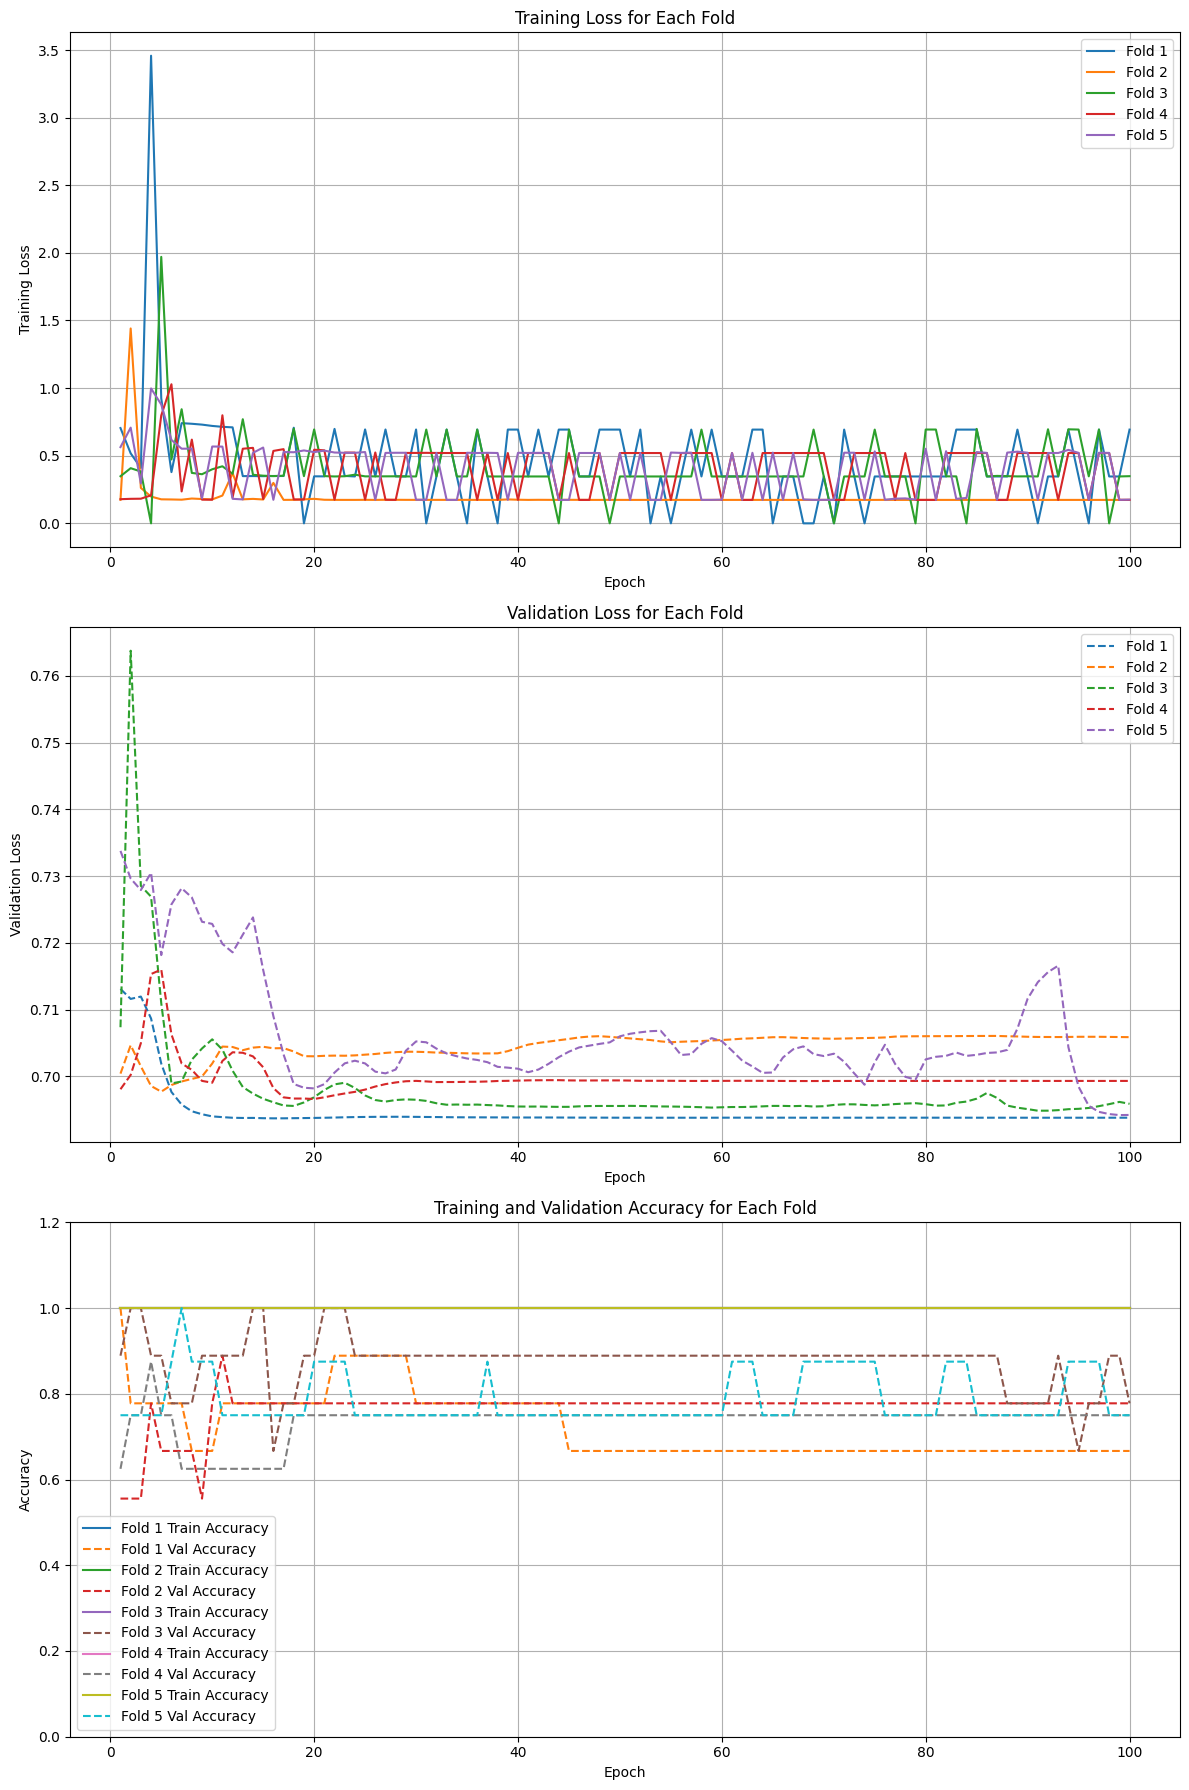

In [ ]:
# Define the target variable and features
X = features
y = labels
train_and_evaluate(few_shot_size=8, epochs=100, n_splits=5)


# Train Augmentation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
def apply_pca(X_scaled, variance_threshold=0.99):
    pca = PCA()
    pca.fit(X_scaled)
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_explained_variance >= variance_threshold) + 1
    print(
        f"Number of components needed to explain {variance_threshold * 100}% of the variance: {n_components}"
    )
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    return X_pca, pca


def generate_synthetic_samples(X_pca, y, num_samples=1000):
    synthetic_samples = []
    synthetic_subtypes = []
    unique_subtypes = np.unique(y)
    for subtype in unique_subtypes:
        subtype_indices = np.where(y == subtype)[0]
        num_subtype_samples = int(num_samples * len(subtype_indices) / len(y))
        for _ in range(num_subtype_samples):
            sample_idx = np.random.choice(subtype_indices)
            sample = np.copy(X_pca[sample_idx])
            perturbation = np.random.normal(0, 0.1, sample.shape)
            synthetic_sample = sample + perturbation
            synthetic_samples.append(synthetic_sample)
            synthetic_subtypes.append(subtype)
    return np.array(synthetic_samples), np.array(synthetic_subtypes)


def inverse_transform_samples(synthetic_samples_pca, pca):
    return pca.inverse_transform(synthetic_samples_pca)

def augment_main(X_scaled, y):
    X_pca, pca = apply_pca(X_scaled)
    synthetic_samples_pca, synthetic_subtypes = generate_synthetic_samples(X_pca, y)
    synthetic_samples = inverse_transform_samples(synthetic_samples_pca, pca)
    X_new = np.concatenate([X_scaled, synthetic_samples], axis=0)
    y_new = np.concatenate([y, synthetic_subtypes], axis=0)

    return X_new, y_new

# main(features, labels)

In [ ]:
def train_and_evaluate_with_augment(X, y, few_shot_size=10, epochs=20, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits)
    fold_accuracies = []
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        X_train, y_train = augment_main(X_train, y_train)

        # Select few-shot samples
        train_indices = np.random.choice(len(X_train), few_shot_size, replace=False)
        X_few_shot = X_train[train_indices]
        y_few_shot = y_train[train_indices]

        few_shot_dataset = FewShotDataset(X_few_shot, y_few_shot)
        few_shot_loader = DataLoader(few_shot_dataset, batch_size=2, shuffle=True)

        val_dataset = FewShotDataset(X_test, y_test)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Initialize the model, criterion, and optimizer
        input_dim = X.shape[1]
        hidden_dim = 128
        output_dim = len(np.unique(y))  # Ensure output_dim matches the number of unique classes
        model = ProtoNet(input_dim, hidden_dim, output_dim)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        # Train the model
        for epoch in range(epochs):
            model.train()
            epoch_train_loss = 0
            correct_train = 0
            total_train = 0

            for X_batch, y_batch in few_shot_loader:
                optimizer.zero_grad()
                embeddings = model(X_batch.float())
                prototypes = compute_prototypes(embeddings, y_batch)
                distances = torch.stack([euclidean_distance(embeddings, proto) for proto in prototypes])
                distances = distances.t()  # Transpose to match the expected shape

                # Map the labels to the prototype indices
                unique_labels = torch.unique(y_batch)
                label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}
                y_mapped = torch.tensor([label_map[label.item()] for label in y_batch], dtype=torch.long)

                loss = criterion(distances, y_mapped)
                loss.backward()
                optimizer.step()

                epoch_train_loss += loss.item()
                _, predicted = torch.min(distances, 1)
                correct_train += (predicted == y_mapped).sum().item()
                total_train += y_batch.size(0)

            train_losses.append(epoch_train_loss / len(few_shot_loader))
            train_accuracies.append(correct_train / total_train)

            # Validation phase
            model.eval()
            epoch_val_loss = 0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for X_batch, y_batch in val_loader:
                    embeddings = model(X_batch.float())
                    prototypes = compute_prototypes(embeddings, y_batch)
                    distances = torch.stack([euclidean_distance(embeddings, proto) for proto in prototypes])
                    distances = distances.t()  # Transpose to match the expected shape

                    # Map the labels to the prototype indices
                    unique_labels = torch.unique(y_batch)
                    label_map = {label.item(): idx for idx, label in enumerate(unique_labels)}
                    y_mapped = torch.tensor([label_map[label.item()] for label in y_batch], dtype=torch.long)

                    loss = criterion(distances, y_mapped)
                    epoch_val_loss += loss.item()
                    _, predicted = torch.min(distances, 1)
                    correct_val += (predicted == y_mapped).sum().item()
                    total_val += y_batch.size(0)

            val_losses.append(epoch_val_loss / len(val_loader))
            val_accuracies.append(correct_val / total_val)

        fold_train_losses.append(train_losses)
        fold_val_losses.append(val_losses)
        fold_train_accuracies.append(train_accuracies)
        fold_val_accuracies.append(val_accuracies)

        final_val_accuracy = val_accuracies[-1]
        fold_accuracies.append(final_val_accuracy)
        print(f'Fold {fold + 1} validation accuracy: {final_val_accuracy}')

    mean_accuracy = np.mean(fold_accuracies)
    print(f'Mean validation accuracy over {n_splits} folds: {mean_accuracy}')

    # Plotting the training and validation losses and accuracies
    fig, axs = plt.subplots(3, 1, figsize=(12, 18))

    # Plot training loss
    for fold in range(n_splits):
        axs[0].plot(range(1, epochs + 1), fold_train_losses[fold], label=f'Fold {fold + 1}')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Training Loss')
    axs[0].set_title('Training Loss for Each Fold')
    axs[0].legend()
    axs[0].grid(True)

    # Plot validation loss
    for fold in range(n_splits):
        axs[1].plot(range(1, epochs + 1), fold_val_losses[fold], label=f'Fold {fold + 1}', linestyle='--')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Validation Loss')
    axs[1].set_title('Validation Loss for Each Fold')
    axs[1].legend()
    axs[1].grid(True)

    # Plot training and validation accuracies
    for fold in range(n_splits):
        axs[2].plot(range(1, epochs + 1), fold_train_accuracies[fold], label=f'Fold {fold + 1} Train Accuracy')
        axs[2].plot(range(1, epochs + 1), fold_val_accuracies[fold], label=f'Fold {fold + 1} Val Accuracy', linestyle='--')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Accuracy')
    axs[2].set_ylim(0, 1.2)  # Set y-axis limits from 0 to 1
    axs[2].set_title('Training and Validation Accuracy for Each Fold')
    axs[2].legend()
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()



Number of components needed to explain 99.0% of the variance: 31
Fold 1 validation accuracy: 0.6666666666666666
Number of components needed to explain 99.0% of the variance: 30
Fold 2 validation accuracy: 0.6666666666666666
Number of components needed to explain 99.0% of the variance: 31
Fold 3 validation accuracy: 0.7777777777777778
Number of components needed to explain 99.0% of the variance: 31
Fold 4 validation accuracy: 0.5
Number of components needed to explain 99.0% of the variance: 31
Fold 5 validation accuracy: 0.75
Mean validation accuracy over 5 folds: 0.6722222222222223


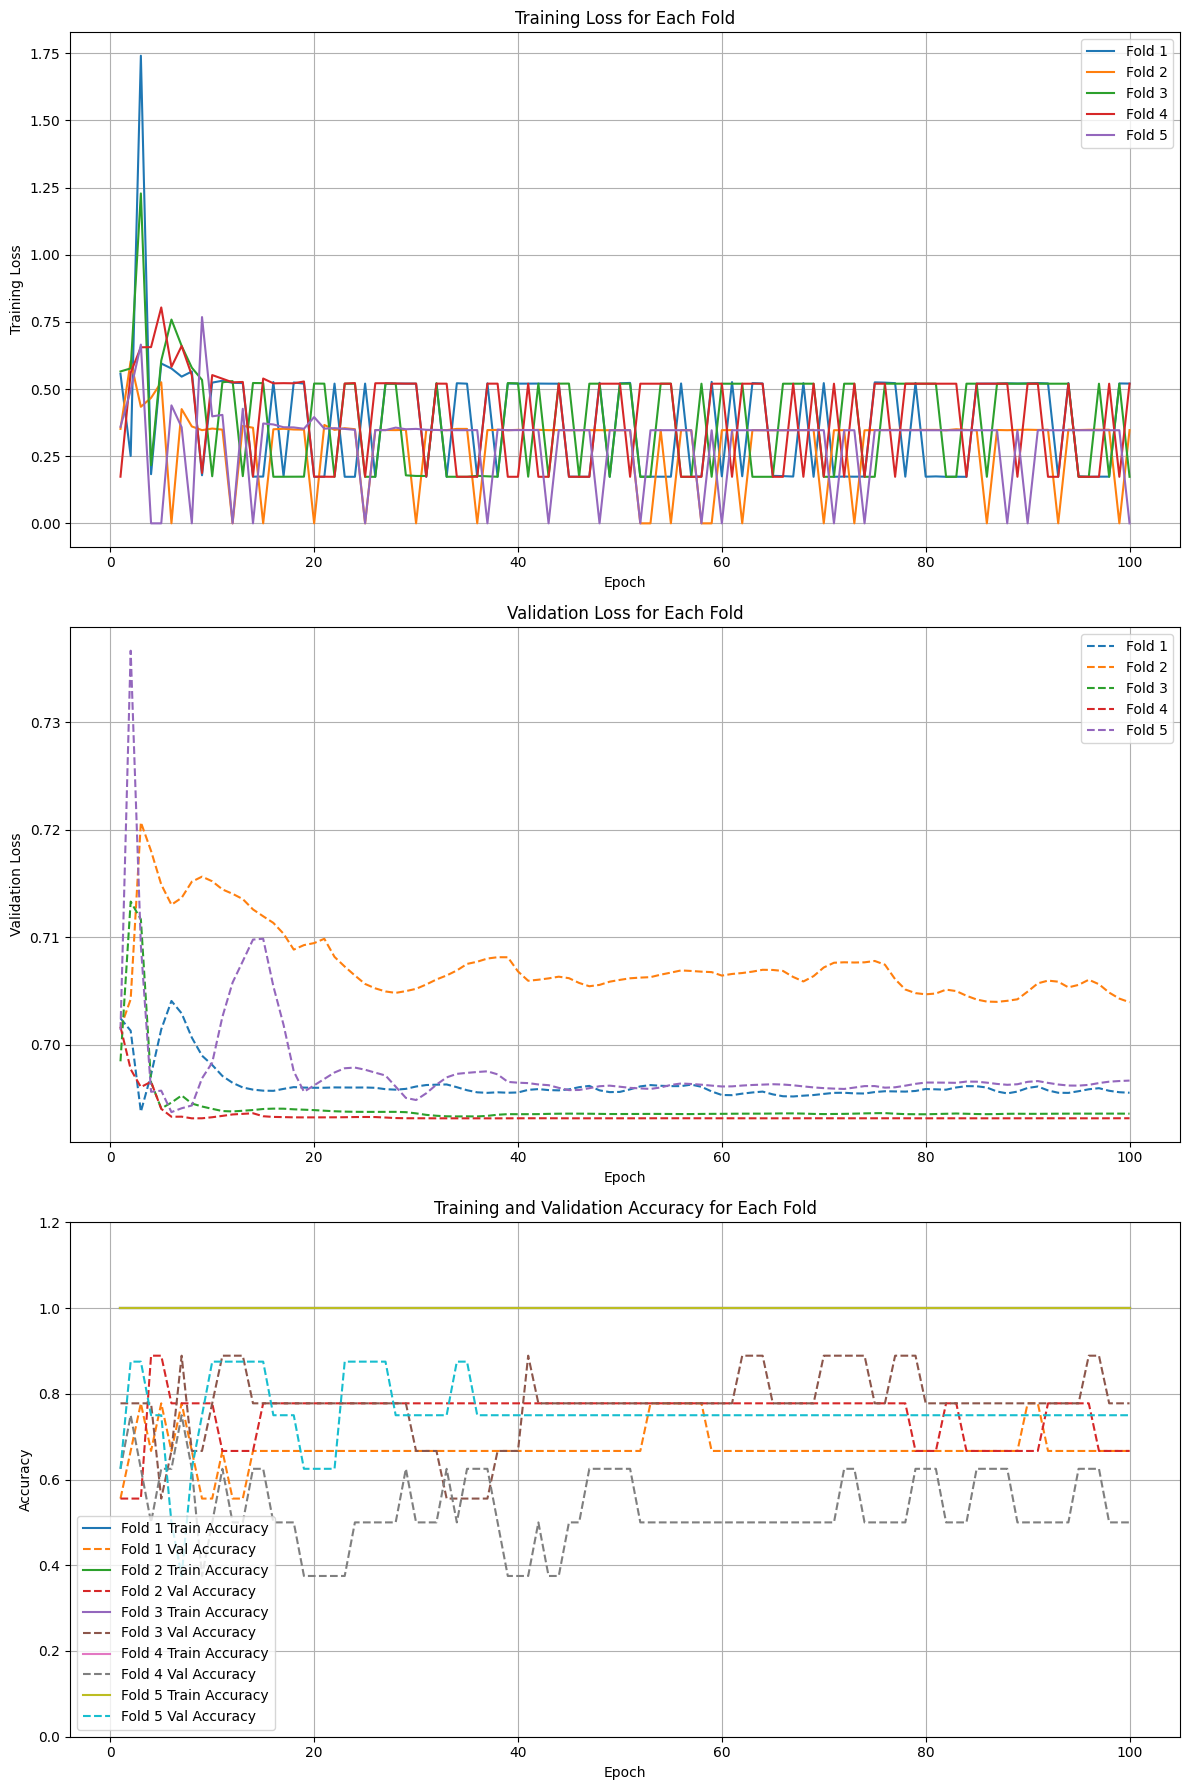

In [ ]:
# Define the target variable and features
X = features
y = labels

train_and_evaluate_with_augment(X, y, few_shot_size=8, epochs=100, n_splits=5)